In [3]:
#Generic Modules
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy import signal
import numpy as np
from scipy.optimize import curve_fit,minimize

#Martin's style
import sys
sys.path.insert(0, './PyQtRod') #insert PyQtRod path to use the reader module NIfile. Change to the location of PyQtRod.
sys.path.insert(0, './PyQtRod/Helpers') #insert PyQtRod path to use the reader module NIfile. Change to the location of PyQtRod.

plt.style.use('./PyQtRod/mr_widget.mplstyle') #my own style, can remove
from MR_jupyter import *
dispwidget()


#Rod's functions
from NIfile import NIfile
from Fourkas import *
from corr_matrix import *
from speeds import *
from functools import partial
from ECF import *






In [29]:
tdmspath = "2022_20_11_MTB32_biotin_rod/pathd.tdms" #file number
dec = 1
f = NIfile(tdmspath,dec=dec,max_size=20000)

print("File of length "+str(len(f.channels[0])))
start =  0#starting index to load file from memory
stop = 3000000



filebeforeOct22 = 1

File of length 119603588


# Initialization

## Load

In [30]:


freq = f.freq
xtime = np.arange(start,stop,1)/250e3*dec


channels = []
for i in range(4):
    channels.append(f.channels[i][start:stop:dec])
pol_ind = f.get_pol_ind(["0","90","45","135"])
C0or,C90or,C45or,C135or = [channels[pol_ind[i]] for i in range(len(pol_ind))]

try:
    del(c0,c90,c45,c135,phi,phiu,phir,theta1,Itot,Itot2stheta)
except:
    "not present"


## Correct optics 

In [31]:
#C0,C90,C45,C135 = correct_with_matrix(C0,C90,C45,C135) #matrix as measured

#Only for files starting from october 2022 (after realignment)

start_opti = 0
end_opti = 100000

if filebeforeOct22 == 0:
    par =  find_best_coeff_using_matrix(C0or[start_opti:end_opti],C90or[start_opti:end_opti],C45or[start_opti:end_opti],C135or[start_opti:end_opti]) 
    C0,C90,C45,C135 = correct_with_matrix(C0or,C90or,C45or,C135or) #matrix as measured
    C90*=par.x[0] #comment if manual
    C45*=par.x[1]  #comment if manual
    C135*=par.x[2]  #comment if manual

#Previous files
if filebeforeOct22 == 1:
    par = find_best_coeff(C0or[start_opti:end_opti],C90or[start_opti:end_opti],C45or[start_opti:end_opti],C135or[start_opti:end_opti])
    C0 = C0or
    C90=C90or*par.x[0] #comment if manual
    C45=C45or*par.x[1]  #comment if manual
    C135=C135or*par.x[2]  #comment if manual
 
#Or manual
#cor = [1,1,1]

#C90*=cor[0]
#C45*=cor[1]
#C135*=cor[2]

#Background

#Background
bg135 = 0.0
bg0 = 0
bg90 = 0
bg45 = bg0+bg90-bg135


C0-=bg0
C90-=bg90
C45-=bg45
C135-=bg135

## Define ROI

In [32]:
def def_roi(rmin,rmax,keep=0):
    global c0,c90,c45,c135,phi,theta1,Itots2theta,Itot,phiu,phir,xt
    c0 = C0[rmin:rmax]
    c90 = C90[rmin:rmax]
    c45 = C45[rmin:rmax]
    c135 = C135[rmin:rmax]
    xt = xtime[rmin:rmax]
    phi,theta1,Itots2theta,Itot = Fourkas(c0,c90,c45,c135,nw=1.33,NA=1.3)#,phi0=result.x[0],theta0=result.x[1])
    phiu = np.unwrap(phi,period=np.pi) #Unwrapped phi in rad
    phir = phiu%(2*np.pi) #Rewrapped phi
    if not keep:
        del(theta1,Itots2theta,Itot)
    
def_roi(0,len(C90))

In [33]:
len(c90)

3000000

# Characteristics

In [ ]:
def_roi(0,500000)

## Characteristics of signals

In [ ]:
f =  plt.figure()

plt.scatter(c0+c90,c45+c135,c=c90,s=0.1)
plt.ylabel("c45+c135")
plt.ylabel("c0+C90")

fig2inline(f)

f =  plt.figure()

plt.hist(c0,100,alpha=0.2)
plt.hist(c90,100,alpha=0.2)
plt.hist(c45,100,alpha=0.2)
plt.hist(c135,100,alpha=0.2)

fig2inline(f)


## Characteristics of trajectories

In [ ]:
Anis090 = (c0 - c90) / (c0 + c90)
Anis45135 = (c45 - c135) / (c45 + c135)

In [ ]:
f= plt.figure(figsize=[6,6],constrained_layout=True)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.title(tdmspath)


plt.plot(Anis090,Anis45135,'.',ms=0.01)
plt.xlabel("0/90 anisotropy")
plt.ylabel("45/135 anisotropy")
fig2inline(f)

f= plt.figure(figsize=[6,6])
plt.plot(c0,c90,'.',ms=0.3)
plt.xlabel("c0")
plt.ylabel("c45")
fig2inline(f)


f = plt.figure(figsize=[6,6])

plt.plot(c45,c135,'.',ms=0.3)
plt.xlabel("c45")
plt.ylabel("c135")
fig2inline(f)


## Spectrum of channels

In [ ]:
#parameters

nperseg = 2**18        # Number of points in a window. If larger than the number of point in Data the spectrum is not averaged
noverlap = nperseg/2    # Overlap between two windows when averaging the spectrum of various windows
nfft = nperseg #Number of points to do the fft. If larger than the number of point in a window this will pad with 0 and smooth the spectrum


In [ ]:

nperseg = np.min([len(c0),nperseg])           # Number of points in a window. If larger than the number of point in Data the spectrum is not averaged
noverlap = nperseg/2    # Overlap between two windows when averaging the spectrum of various windows
nfft = np.min([nfft,len(c0)]) #Number of points to do the fft. If larger than the number of point in a window this will pad with 0 and smooth the spectrum


f = plt.figure()

f0, Pxx_den0 = signal.welch(c0, 250e3, nperseg=nperseg,nfft=nfft,noverlap=noverlap)
f90, Pxx_den90 = signal.welch(c90, 250e3,nperseg=nperseg,nfft=nfft,noverlap=noverlap)
f45, Pxx_den45 = signal.welch(c135, 250e3, nperseg=nperseg,nfft=nfft,noverlap=noverlap)
f135, Pxx_den135 = signal.welch(c45, 250e3, nperseg=nperseg,nfft=nfft,noverlap=noverlap)

plt.plot(f0, Pxx_den0,label="0")
plt.plot(f90, Pxx_den90,label="90")
plt.plot(f45, Pxx_den45,label="45")
plt.plot(f135, Pxx_den135,label="135")


plt.yscale("log")
plt.xscale("log")
plt.xlabel("Freq (Hz)")
plt.ylabel("V/sqrt(Hz)")
plt.legend()

#fig2inline(f)

In [ ]:
f = plt.figure()
plt.hist(c0,1000)
plt.hist(c90,1000)
plt.hist(c45,1000)
plt.hist(c135,1000)

# Compute Fourkas

In [ ]:
phi,theta1,Itots2theta,Itot = Fourkas(c0,c90,c45,c135,nw=1.33,NA=1.3)#,phi0=result.x[0],theta0=result.x[1])
print("There are "+str(len(theta1[np.isnan(theta1)]))+" NAN")

In [ ]:
phiu = np.unwrap(phi,period=np.pi) #Unwrapped phi in rad
phir = phiu%(2*np.pi) #Rewrapped phi
del(theta1,Itots2theta,Itot)

# Phi Characteristics

## Phi histogram

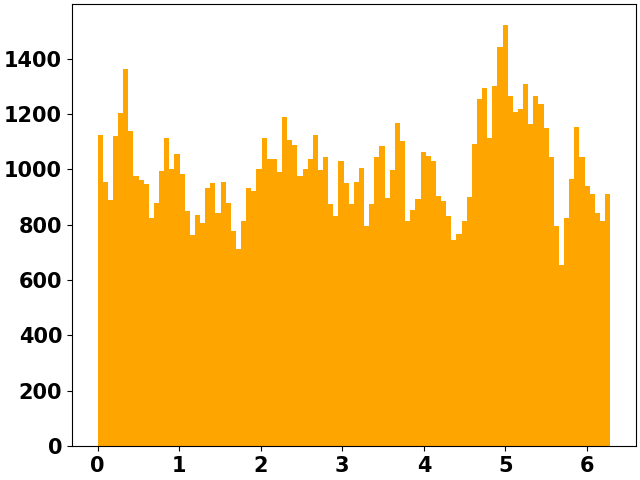

In [12]:
f = plt.figure(dpi=100,constrained_layout=True)
n,p,s = plt.hist(phir[:100000],100)
fig2inline(f)

## Itot 

In [ ]:
ind1=np.where(~np.isnan(theta1))
theta1 = theta1[ind1]
Itot=Itot[ind1]
Itots2theta=Itots2theta[ind1]

f = plt.figure()
plt.hist2d(theta1,Itots2theta,100,cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel("Theta")
plt.ylabel("Itot")
plt.title(tdmspath)
fig2inline(f)

f = plt.figure()
ind = np.where(Itot<60)

plt.hist2d(theta1[ind],Itots2theta[ind]/np.sin(theta1[ind])**2,100,cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel("Theta")
plt.ylabel("Itot/sin(theta)²")
plt.title(tdmspath)
fig2inline(f)

# Show Phi

Text(0.5, 0, 'Time')

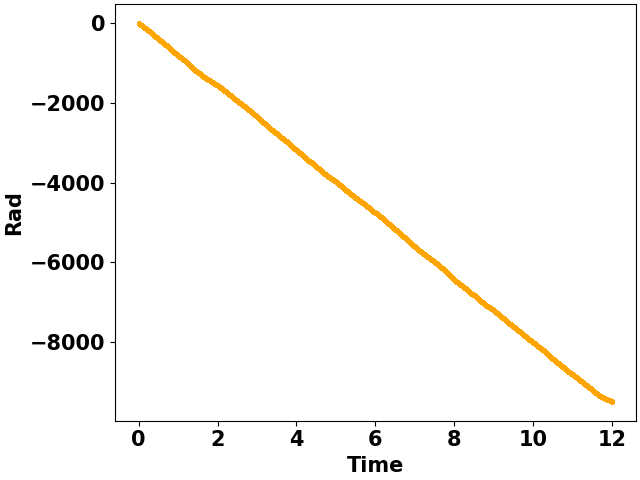

In [34]:
%matplotlib widget
f = plt.figure(dpi=100,constrained_layout=True)
ind = np.where(np.logical_and(xt>52.2,xt<52.3))
plt.plot(xt,phiu,".",ms=4)
np.std(phiu[ind])*180/np.pi
plt.ylabel("Rad")
plt.xlabel("Time")

In [ ]:
v = np.diff(phiu)/(xtime[1]-xtime[0])/2/np.pi

In [ ]:
vf=np.convolve(v,np.ones(200),'same')/200

In [ ]:
%matplotlib widget
f = plt.figure(dpi=100,constrained_layout=True)
plt.title(tdmspath)
plt.ylabel("Speed (Hz)")
plt.xlabel("Time (s)")
plt.plot(xt[1:],vf)

In [ ]:
plt.figure()
n,p,s=plt.hist(vf,1000)

# Speed 

In [ ]:
med = signal.medfilt(np.diff(phiu[:1000000]), kernel_size=1001)

In [ ]:
med2 = signal.medfilt(med2, kernel_size=1001)

In [ ]:
plt.figure()
plt.plot(xtime[:999999],med[:])

# Spectrum of phi

In [ ]:
#parameters

nperseg = 2**18        # Number of points in a window. If larger than the number of point in Data the spectrum is not averaged
noverlap = nperseg/2    # Overlap between two windows when averaging the spectrum of various windows
nfft = nperseg #Number of points to do the fft. If larger than the number of point in a window this will pad with 0 and smooth the spectrum


In [ ]:

nperseg = np.min([len(c0),nperseg])           # Number of points in a window. If larger than the number of point in Data the spectrum is not averaged
novCopy3erlap = nperseg/2    # Overlap between two windows when averaging the spectrum of various windows
nfft = np.min([nfft,len(c0)]) #Number of points to do the fft. If larger than the number of point in a window this will pad with 0 and smooth the spectrum


f = plt.figure(dpi=200,constrained_layout=True)

f0, Pxx_den0 = signal.welch(phiu, 250e3, nperseg=nperseg,nfft=nfft,noverlap=noverlap)
plt.plot(f0, Pxx_den0,label="phi")

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Freq (Hz)")
plt.ylabel("rad²/Hz")
plt.legend()
fig2inline(f)

# ECF

In [13]:
import importlib
import ECF
importlib.reload(ECF)
from ECF import * # or whatever name you want.


In [35]:
def_roi(0,10000000)


In [36]:
#parameters
nstepmax = 10000 #max number of steps
nwindow = 400 #sier of window
modemax = 80 #maximum mode to study
modemin = 1 #minimum mode to study

nshift = int(nwindow/2)

In [37]:
modelist,ftl,nstep,winlist = ECF(phir,nstepmax=nstepmax,nwindow=nwindow,nshift=nshift,modemin=modemin,modemax=modemax)


2022-11-20 19:22:15,448	INFO worker.py:1518 -- Started a local Ray instance.
(raylet) /home/martin/.local/lib/python3.10/site-packages/ray/dashboard/agent.py:50: DeprecationWarning: There is no current event loop
(raylet)   aiogrpc.init_grpc_aio()
(raylet) /home/martin/.local/lib/python3.10/site-packages/ray/dashboard/agent.py:470: DeprecationWarning: There is no current event loop
(raylet)   loop = asyncio.get_event_loop()
100%|███████████████████████████████████████████| 79/79 [00:07<00:00, 10.61it/s]


In [20]:
len(winlist),len(c0)

(10000, 3000000)

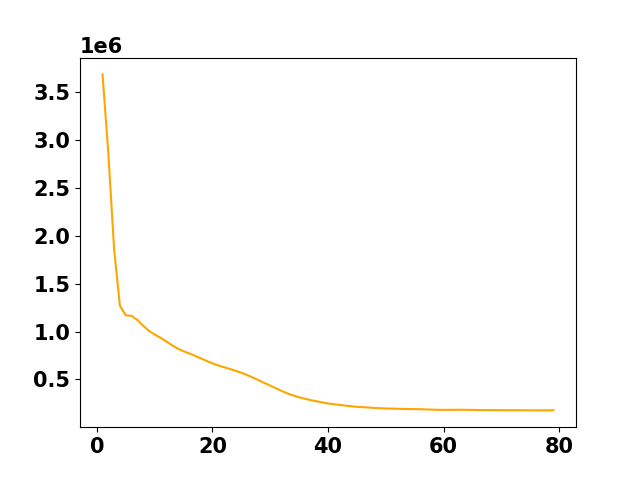

In [38]:
plt.figure()
plt.plot(modelist,ftl)

# Non-linear speed

In [ ]:
def_roi(0,len(C0or))

In [ ]:
al,bl,fitted = compute_speed_best_lin_fit(xt,phiu,2000)

In [ ]:
plt.figure()
plt.hist(al*180/np.pi,100)
plt.show()

In [ ]:
plt.figure(constrained_layout=True)
plt.plot(xt[ind],phiu[ind]/2/np.pi)
#plt.plot(xt,fitted)
plt.xlabel("Time (s)")
plt.ylabel("Angle (turns)")
plt.title(tdmspath)

# Step finding

In [ ]:
import  importlib,step_detect
importlib.reload(step_detect)
from step_detect import filter_step # or whatever name you want.
from sklearn.metrics import pairwise_distances as pwdd

In [ ]:
def_roi(0,5000000)

In [ ]:
from scipy import ndimage

In [ ]:
plt.figure()
xm = 52.245
xmax= 52.285
#plt.plot(xt,fitted)
plt.xlabel("Time (s)")
plt.ylabel("Angle (turns)")
plt.title(tdmspath)
#plt.xlim([xm,xmax])
ind = np.where(np.logical_and(xt>xm,xt<xmax))
#plt.ylim([phiu[ind[0][-1]]/2/np.pi,phiu[ind[0][0]]/2/np.pi])
plt.plot(xt[ind],phiu[ind]/2/np.pi)

t=1.1e-8
n=5
#filtered,p2,step_sizes = filter_step(phiu[ind]/2/np.pi,n=n,windowavsteps=500,t=t)
#filtered,p2,step_sizes = filter_step(phiu[ind]/2/np.pi,n=n,windowavsteps=500,t=t)
filtered = ndimage.median_filter(phiu[ind]/2/np.pi,35)

plt.plot(xt[ind],filtered,'r')


In [ ]:
from sklearn.metrics import pairwise_distances as pwdd

In [ ]:
xm2 = 52.25
xmax2= 52.29
#plt.plot(xt,fitted)
ind2 = np.where(np.logical_and(xt>xm,xt<xmax))


#distances = pwdd(phiu[ind].reshape([-1,1])/2/np.pi) #in turn
#distances = distances.flatten()


In [ ]:
plt.figure()
n,p,s=plt.hist(distances,500)
plt.title("Histogram of pairwise distances (unwrapped angles)")
plt.ylabel("Counts")
plt.xlabel("Pairwise distance (in turns)")


In [ ]:
plt.figure()
n,p=np.histogram(filtered,60)
ind = signal.find_peaks(n,distance=4)[0]
plt.bar(p[1:],n,width=p[1]-p[0])
ind2 = np.where(p[ind]>-32.05)
plt.plot(p[ind+1],n[ind],'.',color="r")


In [ ]:
%matplotlib inline
plt.figure(dpi=100)
plt.plot(np.diff(p[ind]),".")
plt.ylim([0,0.06])
plt.xlabel("step nb")
plt.ylabel("step size (turn)")

In [ ]:
1/0.06

In [ ]:
plt.figure()
step_sizes = np.array(step_sizes)
step_sizes = step_sizes[np.where(np.abs(np.array(step_sizes))>1/100)]
plt.hist(np.reciprocal(step_sizes),30)
plt.xlim([-100,100])
zer= plt.xticks(np.arange(-100,101,10))
plt.xlabel("Periodicity (1/stepsize)")
plt.ylabel("counts")
plt.title("Step finding, threshold = "+str(t)+ " n = "+str(n)+"\n "+tdmspath + "["+str(xm)+","+str(xmax)+"]")

In [ ]:
n,p=np.histogram(filtered,100)
indpeaks = signal.find_peaks(n,prominence=20)[0]
xpeaks = p[1+indpeaks]
npeaks = n[indpeaks]

In [ ]:
plt.figure()
plt.plot(p[1:],n)
plt.plot(xpeaks,npeaks,'.')

In [ ]:
plt.figure()
plt.hist(np.diff(xpeaks),20)

In [ ]:
angles = [0.1479,0.1792,0.2133,0.2474,0.2824,0.3260,0.3553,0.3989,0.4179,0.4349,0.4671,0.5078]

In [ ]:
l=np.diff(xpeaks)
plt.figure(constrained_layout=1)
plt.plot(l,'.')
plt.ylim([0,0.06])
plt.axhline(np.mean(l))
plt.ylabel("Distance between peaks (turn)")
plt.xlabel("Peak")
plt.text(4,np.mean(l)+0.001,"mean = "+str(round(np.mean(l),3)) + "= 1/"+str(round(1/np.mean(l))),c='orange')

In [ ]:
distances = pwdd(filtered.reshape([-1,1])/2/np.pi)

In [ ]:
distances.shape

In [ ]:
plt.figure()
indh=np.where(distances<0.3)
n,p,s=plt.hist(distances[indh].flatten(),10)


In [ ]:
def_roi(0,50000000)

In [ ]:
np.save("Declan_2022_10_26_phi.npy",phiu[:50000000])

In [ ]:
len(phiu)